<a href="https://colab.research.google.com/github/sharon-kathambi/BUSI-Dataset-UNET-/blob/main/BUSI_Dataset_UNET%2B%2B_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install segmentation-models-pytorch torch torchvision albumentations opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


In [6]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-wpx24_pw
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-wpx24_pw
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 4d20629756005085ca0f1f21605c796298ca0c16
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.5.1.dev0-py3-none-any.whl size=155806 sha256=225baef5913f412433ae153ebc026b2b3a5ac8bcf6d90f42041e4ec6261b2b76
  Stored in directory: /tmp/pip-ephem-wheel-cache-974qypmy/wheels/ef/38/4b/267c9bdb27c85ebaa11e9ec77c9059cf2c166ceee760f24429
Successfully built segmentation_models_pytorch
  Attempting uninstall: segmentation_models_pytorch
    Found existing installation: segmentation_models_pytorch 0.5.0
    Uninstalling segmentati

In [7]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import glob
from glob import glob
paths = glob('/content/drive/MyDrive/data/traindataset/*/*')

print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


There are total of 663 images and 677 masks.


In [10]:
import cv2
import numpy as np
from glob import glob

def load_data(root_path, size=256):
    """
    Load images and masks from a single folder (no separate train/val)
    Combines multiple masks per image if they exist.
    Returns: images (N,H,W,1), masks (N,H,W,1)
    """
    images = []
    masks = []
    x = 0  # flag to combine masks

    files = sorted(glob(root_path))

    for path in files:
        img = cv2.imread(path)
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255.0

        if 'mask' in path.lower():
            if x:
                masks[-1] += img
                masks[-1] = np.array(masks[-1] > 0.5, dtype=np.float32)
            else:
                masks.append(img)
                x = 1
        else:
            images.append(img)
            x = 0

    #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
    #masks  = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)

    images = np.array(images, dtype=np.float32)
    masks  = np.array(masks, dtype=np.float32)

    return images, masks


In [11]:
import albumentations as A

def augment_data(images, masks, augment_factor=5, size=256):
    """
    Perform data augmentation to expand dataset.
    images: numpy array (N,H,W,1)
    masks: numpy array (N,H,W,1)
    augment_factor: how many augmented versions per original image
    Returns: augmented_images, augmented_masks
    """
    augmented_images = []
    augmented_masks  = []

    # Define augmentations
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ])

    for i in range(len(images)):
        img = images[i]
        mask = masks[i]

        for _ in range(augment_factor):
            augmented = transform(image=img, mask=mask)
            aug_img, aug_mask = augmented['image'], augmented['mask']
            augmented_images.append(aug_img)
            augmented_masks.append(aug_mask)

    #augmented_images = np.expand_dims(np.array(augmented_images, dtype=np.float32), axis=-1)
    #augmented_masks  = np.expand_dims(np.array(augmented_masks, dtype=np.float32), axis=-1)

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_masks  = np.array(augmented_masks, dtype=np.float32)

    return augmented_images, augmented_masks


In [12]:
import torch
from torch.utils.data import Dataset

class NumpyDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        """
        images: numpy array (N,H,W,1)
        masks: numpy array (N,H,W,1)
        transform: optional albumentations transform
        """
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Albumentations expects HWC, so squeeze if (H,W,1)
        #image = image.squeeze(-1)
        #mask  = mask.squeeze(-1)


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        else:
            # If no transform, just convert
            image, mask = image, mask

        # Ensure shapes (H,W) -> (C,H,W)
        image = torch.tensor(image, dtype=torch.float).unsqueeze(0)  # (1,H,W)
        mask  = torch.tensor(mask, dtype=torch.float).unsqueeze(0)   # (1,H,W)

        return image, mask



In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Load raw data
X, Y = load_data("/content/drive/MyDrive/data/traindataset/*/*", size=256)

# Split into train/validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

# Augment training data
augment_factor = 5
X_train_aug, Y_train_aug = augment_data(X_train, Y_train, augment_factor)

# Albumentations transforms (optional additional)
train_transform = A.Compose([
    A.Normalize(),
   # ToTensorV2()
])
val_transform = A.Compose([
    A.Normalize(),
    #ToTensorV2()
])

# Create PyTorch Datasets
train_dataset = NumpyDataset(X_train_aug, Y_train_aug, transform=train_transform)
val_dataset   = NumpyDataset(X_val, Y_val, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Train samples: 2815
Validation samples: 100


In [15]:
for img, mask in train_loader:
    break


In [16]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 25.0 MB/s eta 0:00:00


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [18]:
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
    BinaryJaccardIndex  # IoU
)

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# UNet++ model
model = smp.UnetPlusPlus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metrics (binary segmentation)
accuracy = BinaryAccuracy().to(DEVICE)
iou = BinaryJaccardIndex().to(DEVICE)  # IoU
precision = BinaryPrecision().to(DEVICE)
recall = BinaryRecall().to(DEVICE)
f1 = BinaryF1Score().to(DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [20]:
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))


In [21]:
EPOCHS = 50

# To store history
history = {
    "train_loss": [], "val_loss": [],
    "accuracy": [], "iou": [], "precision": [], "recall": [], "f1": []
}

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average train loss
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    # Reset metrics
    accuracy.reset(); iou.reset(); precision.reset(); recall.reset(); f1.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            accuracy.update(preds, masks.int())
            iou.update(preds, masks.int())
            precision.update(preds, masks.int())
            recall.update(preds, masks.int())
            f1.update(preds, masks.int())

    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

    # Compute metrics
    acc_val = accuracy.compute().item()
    iou_val = iou.compute().item()
    prec_val = precision.compute().item()
    rec_val = recall.compute().item()
    f1_val = f1.compute().item()

    history["accuracy"].append(acc_val)
    history["iou"].append(iou_val)
    history["precision"].append(prec_val)
    history["recall"].append(rec_val)
    history["f1"].append(f1_val)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc_val:.4f} | IoU: {iou_val:.4f} | "
          f"Precision: {prec_val:.4f} | Recall: {rec_val:.4f} | F1: {f1_val:.4f}")


Validation Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch 1/50 | Train Loss: 0.6185 | Val Loss: 0.4284 | Acc: 0.9587 | IoU: 0.5511 | Precision: 0.7874 | Recall: 0.6475 | F1: 0.7106


Validation Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 2/50 | Train Loss: 0.4115 | Val Loss: 0.8160 | Acc: 0.3325 | IoU: 0.1035 | Precision: 0.1037 | Recall: 0.9850 | F1: 0.1876


Validation Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 3/50 | Train Loss: 0.3253 | Val Loss: 0.7902 | Acc: 0.9311 | IoU: 0.1215 | Precision: 0.9808 | Recall: 0.1218 | F1: 0.2167


Validation Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 4/50 | Train Loss: 0.2778 | Val Loss: 0.9664 | Acc: 0.9231 | IoU: 0.0169 | Precision: 0.9971 | Recall: 0.0169 | F1: 0.0332


Validation Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 5/50 | Train Loss: 0.2610 | Val Loss: 0.6913 | Acc: 0.9361 | IoU: 0.1904 | Precision: 0.9533 | Recall: 0.1921 | F1: 0.3198


Validation Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 6/50 | Train Loss: 0.2370 | Val Loss: 0.9899 | Acc: 0.9221 | IoU: 0.0042 | Precision: 0.9724 | Recall: 0.0042 | F1: 0.0084


Validation Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 7/50 | Train Loss: 0.2369 | Val Loss: 0.3697 | Acc: 0.9466 | IoU: 0.4531 | Precision: 0.6957 | Recall: 0.5651 | F1: 0.6236


Validation Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 8/50 | Train Loss: 0.2516 | Val Loss: 0.3598 | Acc: 0.9550 | IoU: 0.4560 | Precision: 0.8945 | Recall: 0.4820 | F1: 0.6264


Validation Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Epoch 9/50 | Train Loss: 0.2124 | Val Loss: 0.8429 | Acc: 0.1682 | IoU: 0.0859 | Precision: 0.0859 | Recall: 0.9995 | F1: 0.1583


Validation Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 10/50 | Train Loss: 0.2081 | Val Loss: 0.3922 | Acc: 0.9434 | IoU: 0.4263 | Precision: 0.6731 | Recall: 0.5376 | F1: 0.5978


Validation Epoch 11: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Epoch 11/50 | Train Loss: 0.2052 | Val Loss: 0.2248 | Acc: 0.9655 | IoU: 0.6094 | Precision: 0.8420 | Recall: 0.6881 | F1: 0.7573


Validation Epoch 12: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 12/50 | Train Loss: 0.1945 | Val Loss: 0.3448 | Acc: 0.9518 | IoU: 0.4618 | Precision: 0.7856 | Recall: 0.5284 | F1: 0.6318


Validation Epoch 13: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Epoch 13/50 | Train Loss: 0.1807 | Val Loss: 0.8677 | Acc: 0.9294 | IoU: 0.0990 | Precision: 0.9843 | Recall: 0.0991 | F1: 0.1801


Validation Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Epoch 14/50 | Train Loss: 0.1726 | Val Loss: 0.7269 | Acc: 0.9340 | IoU: 0.1654 | Precision: 0.9406 | Recall: 0.1672 | F1: 0.2839


Validation Epoch 15: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 15/50 | Train Loss: 0.1732 | Val Loss: 0.7449 | Acc: 0.5612 | IoU: 0.1484 | Precision: 0.1489 | Recall: 0.9773 | F1: 0.2584


Validation Epoch 16: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Epoch 16/50 | Train Loss: 0.1591 | Val Loss: 0.8405 | Acc: 0.1886 | IoU: 0.0876 | Precision: 0.0876 | Recall: 0.9958 | F1: 0.1611


Validation Epoch 17: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


Epoch 17/50 | Train Loss: 0.1702 | Val Loss: 0.9998 | Acc: 0.9218 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Validation Epoch 18: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Epoch 18/50 | Train Loss: 0.1976 | Val Loss: 0.7587 | Acc: 0.9314 | IoU: 0.1289 | Precision: 0.9518 | Recall: 0.1297 | F1: 0.2284


Validation Epoch 19: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 19/50 | Train Loss: 0.1826 | Val Loss: 0.6275 | Acc: 0.9397 | IoU: 0.2341 | Precision: 0.9705 | Recall: 0.2358 | F1: 0.3794


Validation Epoch 20: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Epoch 20/50 | Train Loss: 0.1852 | Val Loss: 0.8652 | Acc: 0.9280 | IoU: 0.0861 | Precision: 0.9306 | Recall: 0.0866 | F1: 0.1585


Validation Epoch 21: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 21/50 | Train Loss: 0.1801 | Val Loss: 0.8389 | Acc: 0.2103 | IoU: 0.0887 | Precision: 0.0889 | Recall: 0.9829 | F1: 0.1630


Validation Epoch 22: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Epoch 22/50 | Train Loss: 0.1444 | Val Loss: 0.8773 | Acc: 0.9267 | IoU: 0.0654 | Precision: 0.9649 | Recall: 0.0655 | F1: 0.1227


Validation Epoch 23: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Epoch 23/50 | Train Loss: 0.1461 | Val Loss: 0.7146 | Acc: 0.9325 | IoU: 0.1518 | Precision: 0.9017 | Recall: 0.1544 | F1: 0.2636


Validation Epoch 24: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 24/50 | Train Loss: 0.1422 | Val Loss: 0.4023 | Acc: 0.9537 | IoU: 0.4260 | Precision: 0.9346 | Recall: 0.4391 | F1: 0.5975


Validation Epoch 25: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


Epoch 25/50 | Train Loss: 0.1262 | Val Loss: 0.8515 | Acc: 0.9260 | IoU: 0.0713 | Precision: 0.7970 | Recall: 0.0726 | F1: 0.1330


Validation Epoch 26: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Epoch 26/50 | Train Loss: 0.1221 | Val Loss: 0.3421 | Acc: 0.9559 | IoU: 0.4804 | Precision: 0.8588 | Recall: 0.5216 | F1: 0.6490


Validation Epoch 27: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Epoch 27/50 | Train Loss: 0.1490 | Val Loss: 1.0000 | Acc: 0.9218 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Validation Epoch 28: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 28/50 | Train Loss: 0.1412 | Val Loss: 0.3295 | Acc: 0.9524 | IoU: 0.4969 | Precision: 0.7419 | Recall: 0.6008 | F1: 0.6639


Validation Epoch 29: 100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


Epoch 29/50 | Train Loss: 0.1272 | Val Loss: 0.2223 | Acc: 0.9659 | IoU: 0.6252 | Precision: 0.8172 | Recall: 0.7269 | F1: 0.7694


Validation Epoch 30: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 30/50 | Train Loss: 0.1177 | Val Loss: 0.2080 | Acc: 0.9682 | IoU: 0.6593 | Precision: 0.8024 | Recall: 0.7871 | F1: 0.7947


Validation Epoch 31: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 31/50 | Train Loss: 0.1379 | Val Loss: 0.7377 | Acc: 0.8909 | IoU: 0.1782 | Precision: 0.3026 | Recall: 0.3023 | F1: 0.3024


Validation Epoch 32: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


Epoch 32/50 | Train Loss: 0.1255 | Val Loss: 0.7427 | Acc: 0.7351 | IoU: 0.1596 | Precision: 0.1751 | Recall: 0.6433 | F1: 0.2753


Validation Epoch 33: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Epoch 33/50 | Train Loss: 0.1254 | Val Loss: 0.3250 | Acc: 0.9591 | IoU: 0.5117 | Precision: 0.8847 | Recall: 0.5482 | F1: 0.6770


Validation Epoch 34: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Epoch 34/50 | Train Loss: 0.1120 | Val Loss: 0.9613 | Acc: 0.9231 | IoU: 0.0168 | Precision: 0.9797 | Recall: 0.0168 | F1: 0.0331


Validation Epoch 35: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 35/50 | Train Loss: 0.1039 | Val Loss: 1.0000 | Acc: 0.9218 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Validation Epoch 36: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 36/50 | Train Loss: 0.1035 | Val Loss: 0.8356 | Acc: 0.2283 | IoU: 0.0906 | Precision: 0.0907 | Recall: 0.9827 | F1: 0.1661


Validation Epoch 37: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 37/50 | Train Loss: 0.1027 | Val Loss: 0.7776 | Acc: 0.8449 | IoU: 0.1424 | Precision: 0.2006 | Recall: 0.3292 | F1: 0.2493


Validation Epoch 38: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 38/50 | Train Loss: 0.1159 | Val Loss: 0.9239 | Acc: 0.9245 | IoU: 0.0354 | Precision: 0.9923 | Recall: 0.0354 | F1: 0.0684


Validation Epoch 39: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 39/50 | Train Loss: 0.1028 | Val Loss: 0.2874 | Acc: 0.9609 | IoU: 0.5370 | Precision: 0.8802 | Recall: 0.5794 | F1: 0.6988


Validation Epoch 40: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 40/50 | Train Loss: 0.0898 | Val Loss: 0.3335 | Acc: 0.9577 | IoU: 0.4896 | Precision: 0.8991 | Recall: 0.5180 | F1: 0.6573


Validation Epoch 41: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


Epoch 41/50 | Train Loss: 0.0972 | Val Loss: 0.9554 | Acc: 0.8480 | IoU: 0.0246 | Precision: 0.0471 | Recall: 0.0490 | F1: 0.0480


Validation Epoch 42: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 42/50 | Train Loss: 0.1110 | Val Loss: 0.9876 | Acc: 0.8716 | IoU: 0.0070 | Precision: 0.0174 | Recall: 0.0116 | F1: 0.0139


Validation Epoch 43: 100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


Epoch 43/50 | Train Loss: 0.0934 | Val Loss: 0.4178 | Acc: 0.9527 | IoU: 0.4157 | Precision: 0.9239 | Recall: 0.4304 | F1: 0.5872


Validation Epoch 44: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 44/50 | Train Loss: 0.1244 | Val Loss: 0.9405 | Acc: 0.9239 | IoU: 0.0306 | Precision: 0.9124 | Recall: 0.0306 | F1: 0.0593


Validation Epoch 45: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]


Epoch 45/50 | Train Loss: 0.0983 | Val Loss: 0.3015 | Acc: 0.9612 | IoU: 0.5323 | Precision: 0.9039 | Recall: 0.5643 | F1: 0.6948


Validation Epoch 46: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 46/50 | Train Loss: 0.0797 | Val Loss: 0.2802 | Acc: 0.9626 | IoU: 0.5486 | Precision: 0.9086 | Recall: 0.5806 | F1: 0.7085


Validation Epoch 47: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Epoch 47/50 | Train Loss: 0.0904 | Val Loss: 0.9962 | Acc: 0.9219 | IoU: 0.0014 | Precision: 0.9958 | Recall: 0.0014 | F1: 0.0027


Validation Epoch 48: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch 48/50 | Train Loss: 0.0897 | Val Loss: 0.2388 | Acc: 0.9674 | IoU: 0.6093 | Precision: 0.9080 | Recall: 0.6494 | F1: 0.7572


Validation Epoch 49: 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Epoch 49/50 | Train Loss: 0.0779 | Val Loss: 0.8398 | Acc: 0.1928 | IoU: 0.0879 | Precision: 0.0879 | Recall: 0.9943 | F1: 0.1616


Validation Epoch 50: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]

Epoch 50/50 | Train Loss: 0.0804 | Val Loss: 0.7174 | Acc: 0.9282 | IoU: 0.1873 | Precision: 0.6196 | Recall: 0.2116 | F1: 0.3155


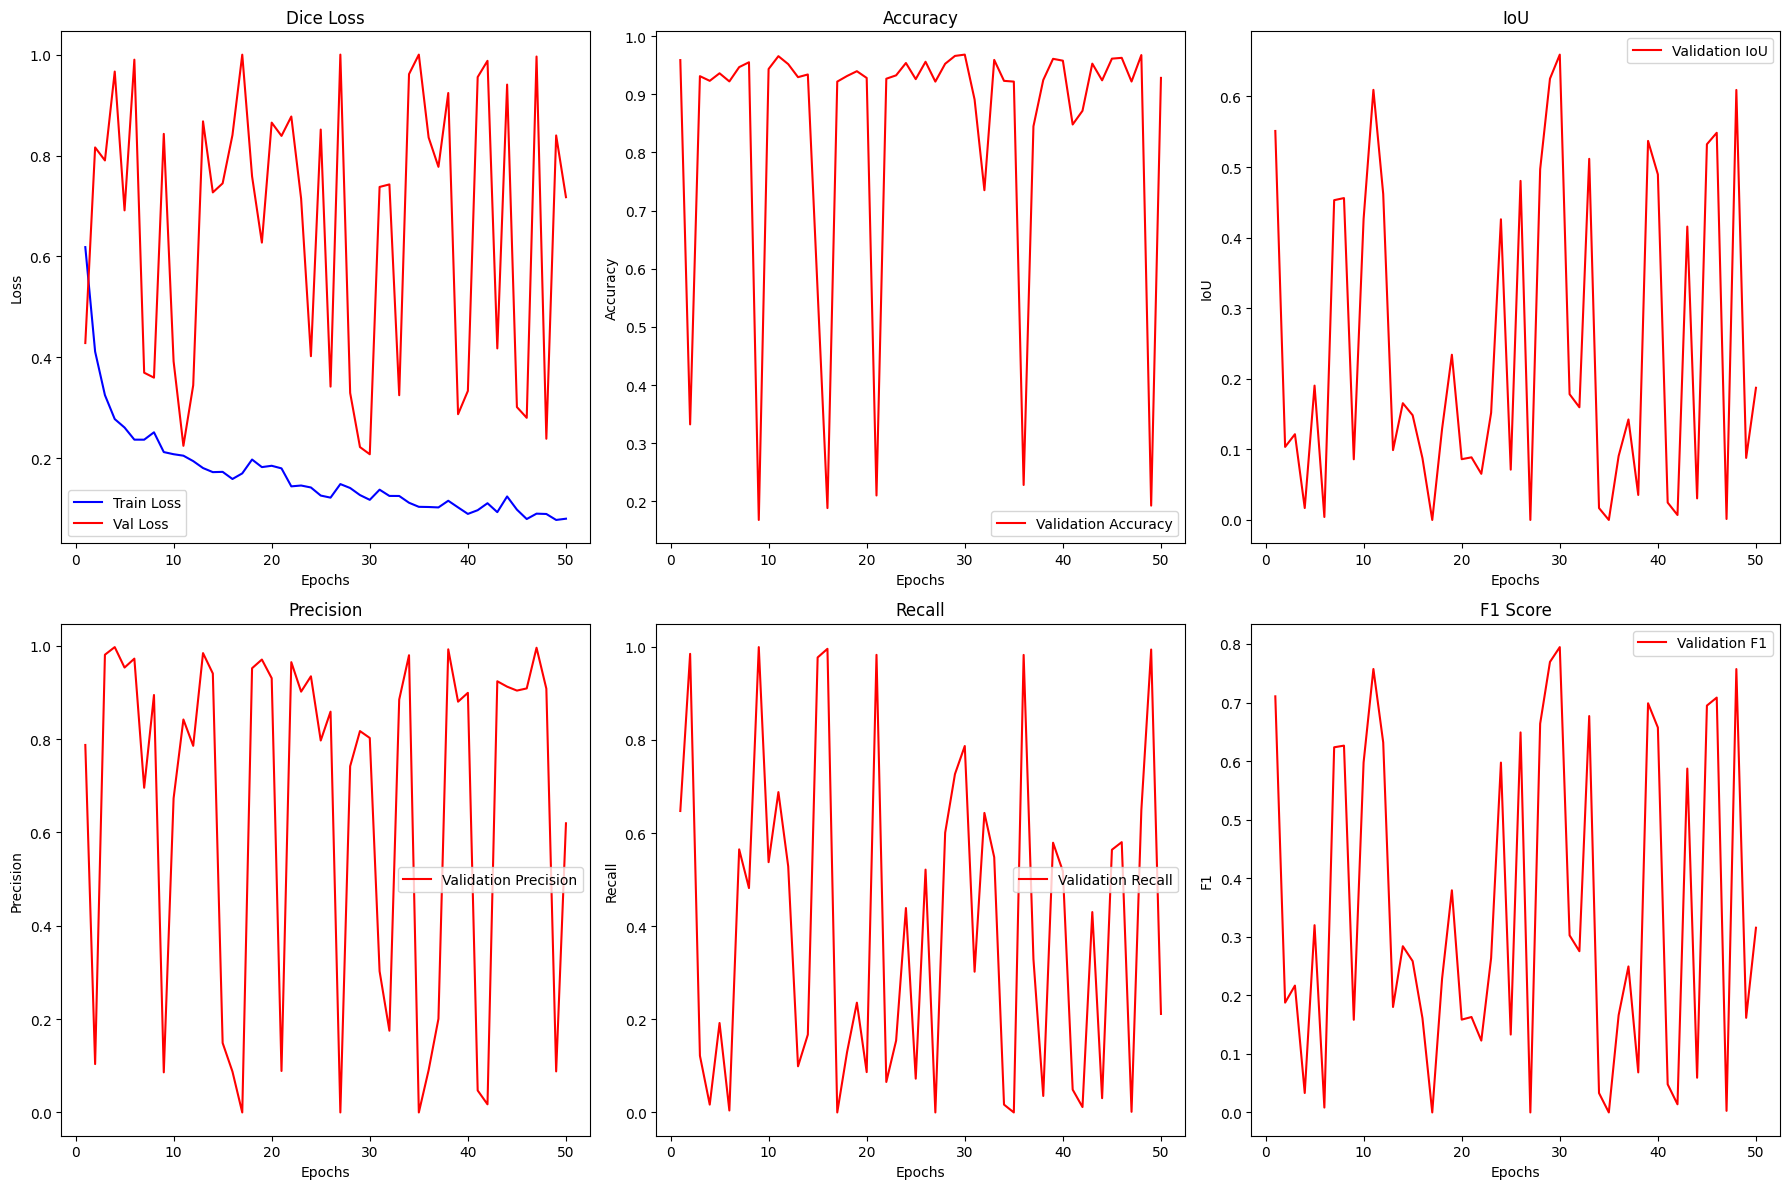

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS+1)

plt.figure(figsize=(18,12))

# Loss
plt.subplot(2,3,1)
plt.plot(epochs, history["train_loss"], 'b-', label='Train Loss')
plt.plot(epochs, history["val_loss"], 'r-', label='Val Loss')
plt.title("Dice Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

# Accuracy
plt.subplot(2,3,2)
plt.plot(epochs, history["accuracy"], 'r-', label='Validation Accuracy')
plt.title("Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

# IoU
plt.subplot(2,3,3)
plt.plot(epochs, history["iou"], 'r-', label='Validation IoU')
plt.title("IoU"); plt.xlabel("Epochs"); plt.ylabel("IoU"); plt.legend()

# Precision
plt.subplot(2,3,4)
plt.plot(epochs, history["precision"], 'r-', label='Validation Precision')
plt.title("Precision"); plt.xlabel("Epochs"); plt.ylabel("Precision"); plt.legend()

# Recall
plt.subplot(2,3,5)
plt.plot(epochs, history["recall"], 'r-', label='Validation Recall')
plt.title("Recall"); plt.xlabel("Epochs"); plt.ylabel("Recall"); plt.legend()

# F1
plt.subplot(2,3,6)
plt.plot(epochs, history["f1"], 'r-', label='Validation F1')
plt.title("F1 Score"); plt.xlabel("Epochs"); plt.ylabel("F1"); plt.legend()

plt.tight_layout()
plt.show()


Evaluating test data

In [30]:
# Example: if you have test data in a separate folder
X_test, Y_test = load_data("/content/drive/MyDrive/data/testdataset/*/*", size=256)

test_transform = A.Compose([
    A.Normalize(),
    #ToTensorV2()
])

test_dataset = NumpyDataset(X_test, Y_test, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Test samples:", len(test_dataset))


Test samples: 117


In [31]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits: raw outputs from model (B,1,H,W)
        targets: ground truth masks (B,1,H,W)
        """
        probs = torch.sigmoid(logits)  # convert logits to probabilities
        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice_score = (2.0 * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice_score  # Dice loss


In [32]:
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchmetrics.segmentation import DiceScore, MeanIoU

def evaluate_model(model, loader, device="cuda"):
    model.eval()
    criterion = DiceLoss().to(device)
    total_loss = 0
    num_batches = len(loader)

    # Metrics
    accuracy  = BinaryAccuracy().to(device)
    precision = BinaryPrecision().to(device)
    recall    = BinaryRecall().to(device)
    f1        = BinaryF1Score().to(device)
    iou       = MeanIoU(num_classes=2).to(device)
    dice      = DiceScore(num_classes=2).to(device)

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_bin = (preds > 0.5).int()

            # Update metrics
            accuracy.update(preds_bin, masks.int())
            precision.update(preds_bin, masks.int())
            recall.update(preds_bin, masks.int())
            f1.update(preds_bin, masks.int())
            iou.update(preds_bin, masks.int())
            dice.update(preds_bin, masks.int())

    results = {
        "loss": total_loss / num_batches,
        "accuracy": accuracy.compute().item(),
        "precision": precision.compute().item(),
        "recall": recall.compute().item(),
        "f1": f1.compute().item(),
        "iou": iou.compute().item(),
        "dice": dice.compute().item()
    }

    return results


In [33]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, device="cuda", num_samples=5):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return  # stop after showing requested number

                img   = images[i].cpu().squeeze().numpy()
                mask  = masks[i].cpu().squeeze().numpy()
                pred  = preds[i].cpu().squeeze().numpy()

                # Plot side-by-side
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img, cmap="gray")
                axs[0].set_title("Image")
                axs[0].axis("off")

                axs[1].imshow(mask, cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(pred, cmap="gray")
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.show()

                samples_shown += 1


📊 Test Results
loss: 0.8067
accuracy: 0.9237
precision: 0.6103
recall: 0.1661
f1: 0.2611
iou: 0.0901
dice: 0.1375


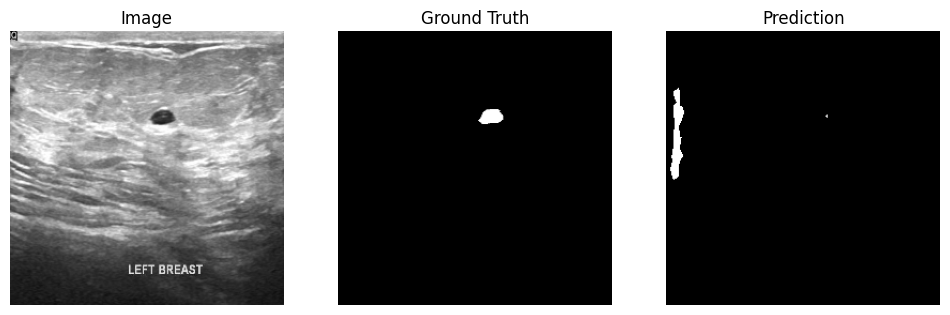

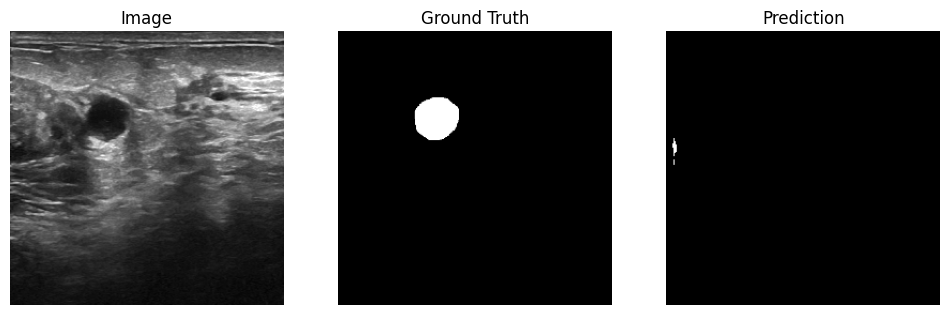

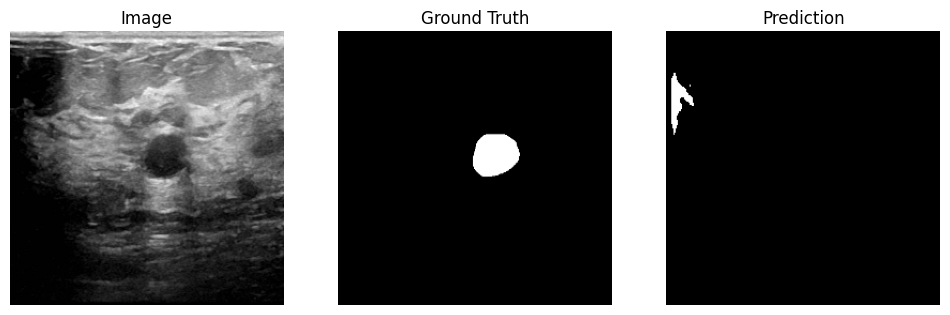

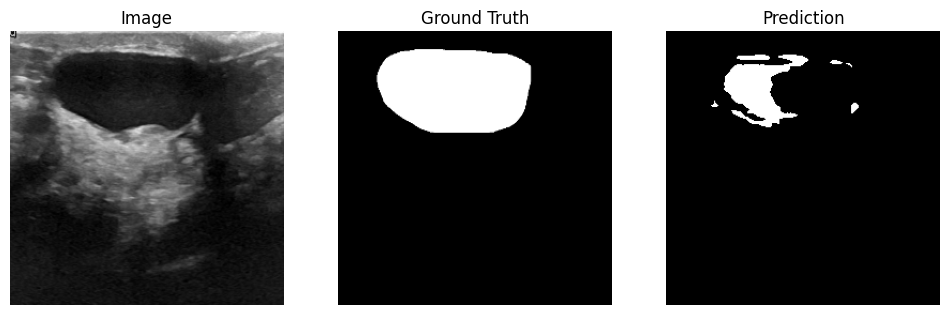

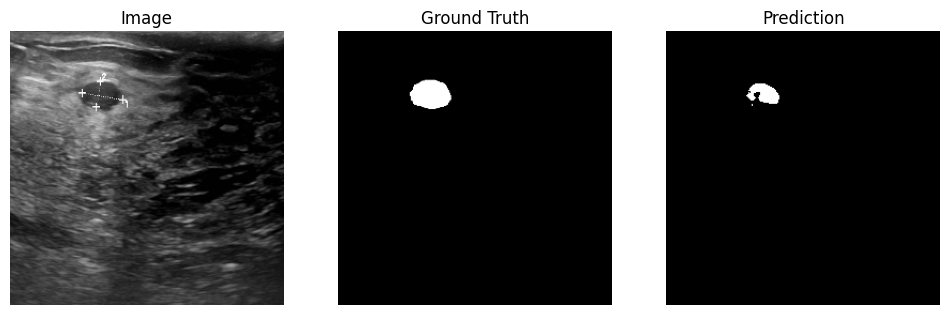

In [34]:
# Evaluate
test_metrics = evaluate_model(model, test_loader, device=DEVICE)
print("📊 Test Results")
for k,v in test_metrics.items():
    print(f"{k}: {v:.4f}")

# Visualize 5 predictions
visualize_predictions(model, test_loader, device=DEVICE, num_samples=5)
